In [3]:
!pip install rdkit-pypi
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=b4ac7e72d52375f10f99a031bf6e5bacc491926e245aecd555ce0908df935c29
  Stored in directory: /Users/alex/Library/Caches/pip/wheels/c3/a4/14/3d4ebf79d3a392ae78ca33ed288f36a1eeff1a191d5eb8fcc6
Successfully built mordred


In [4]:
import pandas as pd
import numpy as np

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors

In [29]:
# import dataset
esol = pd.read_csv("delaney_processed.csv")

# drop some columns to make it less cumbersome to look at
esol.drop(columns=[
    'ESOL predicted log solubility in mols per litre', 
    'Minimum Degree', 
    'Number of H-Bond Donors', 
    'Number of Rings', 
    'Number of Rotatable Bonds', 
    'Polar Surface Area', 
    'measured log solubility in mols per litre'],
    inplace=True)

print(esol.shape)
esol.head()

(1128, 3)


,Compound ID,Molecular Weight,smiles
0,Amigdalin,457.432,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,201.225,Cc1occc1C(=O)Nc2ccccc2
2,citral,152.237,CC(C)=CCCC(C)=CC(=O)
3,Picene,278.354,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,84.143,c1ccsc1


## 1. Generate Canonical SMILES

In [30]:
# generate using rdkit
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

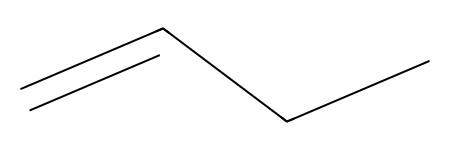

In [31]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

a = Chem.MolFromSmiles('C=CCC')
a

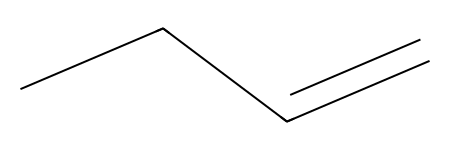

In [32]:
b = Chem.MolFromSmiles('CCC=C')
b

In [33]:
a == b

False

In [34]:
c = canonical_smiles(['C=CCC'])
d = canonical_smiles(['CCC=C'])

c == d

True

We need canonical SMILES so that we can easily remove duplicates.

In [35]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(esol.smiles)
len(Canon_SMILES)

1128

In [36]:
# Put the smiles in the dataframe
esol['SMILES'] = Canon_SMILES
esol

,Compound ID,Molecular Weight,smiles,SMILES
0,Amigdalin,457.432,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,201.225,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1
2,citral,152.237,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O
3,Picene,278.354,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,Thiophene,84.143,c1ccsc1,c1ccsc1
...,...,...,...,...
1123,halothane,197.381,FC(F)(F)C(Cl)Br,FC(F)(F)C(Cl)Br
1124,Oxamyl,219.266,CNC(=O)ON=C(SC)C(=O)N(C)C,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,246.359,CCSCCSP(=S)(OC)OC,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,72.151,CCC(C)C,CCC(C)C


In [37]:
# Create a list for duplicate smiles
duplicates_smiles = esol[esol['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

11

In [38]:
# Filter duplicate smiles by sorting
esol[esol['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

,Compound ID,Molecular Weight,smiles,SMILES
222,2-bromonaphthalene,207.070,c1c(Br)ccc2ccccc12,Brc1ccc2ccccc2c1
554,2-Bromonapthalene,207.070,Brc1ccc2ccccc2c1,Brc1ccc2ccccc2c1
213,eucalyptol,154.253,CC12CCC(CC1)C(C)(C)O2,CC12CCC(CC1)C(C)(C)O2
976,"1,8-Cineole",154.253,CC12CCC(CC1)C(C)(C)O2,CC12CCC(CC1)C(C)(C)O2
232,Epiandrosterone,290.447,CC34CCC1C(CCC2CC(O)CCC12C)C3CCC4=O,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
655,Androsterone,290.447,CC12CCC(O)CC1CCC3C2CCC4(C)C3CCC4=O,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
825,5-Ethyl-5-isopropylbarbituric acid,198.222,O=C1NC(=O)NC(=O)C1(CC)C(C)C,CCC1(C(C)C)C(=O)NC(=O)NC1=O
701,probarbital,198.222,CCC1(C(C)C)C(=O)NC(=O)NC1=O,CCC1(C(C)C)C(=O)NC(=O)NC1=O
147,Amobarbital,226.276,CCC1(CCC(C)C)C(=O)NC(=O)NC1=O,CCC1(CCC(C)C)C(=O)NC(=O)NC1=O
779,5-Ethyl-5-(3-methylbutyl)barbital,226.276,O=C1NC(=O)NC(=O)C1(CC)CCC(C)C,CCC1(CCC(C)C)C(=O)NC(=O)NC1=O


## Drop Duplicate Values

In [45]:
# remove duplicate smiles (also remove old 'smiles' column)
esol_new = esol.drop_duplicates(subset=['SMILES']).drop(columns=['smiles'])
len(esol_new)

1117

In [46]:
esol_new

,Compound ID,Molecular Weight,SMILES
0,Amigdalin,457.432,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,201.225,Cc1occc1C(=O)Nc1ccccc1
2,citral,152.237,CC(C)=CCCC(C)=CC=O
3,Picene,278.354,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,Thiophene,84.143,c1ccsc1
...,...,...,...
1123,halothane,197.381,FC(F)(F)C(Cl)Br
1124,Oxamyl,219.266,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,246.359,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,72.151,CCC(C)C


## Calculate Descriptors using RDkit

**a. General Molecular Descriptors — about 200 molecular descriptors**

In [49]:
def RDkit_descriptors(smiles):
    # convert smiles into their corresponding molecular graphs
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    
    # calculate all descriptors available in RDkit and save to variable
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
        
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(esol_new['SMILES'])

In [50]:
# put descriptors and descriptor names into df
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.069684,-5.122500,10.069684,0.911295,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,0
1,12.547837,-2.999280,12.547837,0.099444,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
2,11.071016,-3.884051,11.071016,1.707414,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
3,8.745488,-0.641794,8.745488,0.260568,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
4,6.980324,-0.134259,6.980324,0.004630,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,11.196181,-4.713735,11.196181,1.906057,0.523506,197.381,196.373,195.890224,44,0,...,0,0,0,0,0,0,0,0,0,0
1113,12.235172,-3.539125,12.235172,0.407085,0.293876,219.266,206.162,219.067762,80,0,...,1,0,0,0,0,0,0,0,0,0
1114,7.801921,-4.552936,7.801921,0.390035,0.506070,246.359,231.239,245.997179,74,0,...,1,0,0,0,0,0,0,0,0,0
1115,7.421875,-3.723958,7.421875,3.530208,0.444441,72.151,60.055,72.093900,32,0,...,0,0,0,0,0,0,0,0,0,0


**b. Fingerprints**

In [52]:
# morgan fingerprints are one of the most commonly used chemical fingerprints
def morgan_fpts(data):
    Morgan_fpts = []
    
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048) # 2="radius of fpt", 2048="length of fpt"
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts) 
        
    return np.array(Morgan_fpts)

In [53]:
Morgan_fpts = morgan_fpts(esol_new['SMILES'])
Morgan_fpts.shape

(1117, 2048)

In [55]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts, columns=['Col_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
Morgan_fingerprints

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1115,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have fingerprints for each molecule. The length of each fingerprint is 2048.

## Calculate Descriptors using Mordred

**there are 1826 descriptors**

In [56]:
def All_Mordred_descriptors(data):
    
    # calculate descriptors for each SMILES
    calc = Calculator(descriptors, ignore_3D=False)
    
    # convert each into a molecular graph
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    
    return df

In [58]:
mordred_descriptors = All_Mordred_descriptors(esol_new['SMILES'])

100%|███████████████████████████████████████████████| 1117/1117 [04:46<00:00,  3.90it/s]


In [59]:
mordred_descriptors.shape

(1117, 1826)

In [60]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,24.334008,19.893690,0,0,41.096001,2.432237,4.864474,41.096001,1.284250,4.378055,...,10.411178,68.045415,457.158411,7.748448,3080,56,164.0,195.0,12.333333,7.250000
1,11.451608,10.427368,0,0,19.259416,2.328912,4.577094,19.259416,1.283961,3.629487,...,9.325721,60.100855,201.078979,7.733807,384,18,74.0,84.0,4.694444,3.388889
2,7.399237,7.388977,0,0,12.133645,2.047810,4.095621,12.133645,1.103059,3.219224,...,8.131825,38.565088,152.120115,5.634078,194,9,42.0,41.0,5.472222,2.750000
3,18.101696,12.688772,0,0,30.943225,2.534800,5.069601,30.943225,1.406510,4.078270,...,10.370455,57.194078,278.109550,7.725265,963,42,128.0,159.0,4.388889,4.694444
4,3.535534,3.535534,0,0,6.472136,2.000000,3.618034,6.472136,1.294427,2.525424,...,7.147559,41.004802,84.003371,9.333708,15,0,20.0,20.0,1.25,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,4.876567,5.209852,0,0,6.602720,2.175328,4.350655,6.602720,0.943246,2.792781,...,8.466531,34.219913,195.890224,24.486278,42,6,30.0,30.0,5.173611,1.500000
1113,9.549067,9.862368,0,0,16.175514,2.220061,4.440122,16.175514,1.155394,3.475164,...,8.896588,43.998691,219.067762,8.113621,337,17,58.0,62.0,7.444444,3.472222
1114,7.937093,8.164337,0,0,14.324780,2.215208,4.430416,14.324780,1.193732,3.315673,...,8.744010,41.128861,245.997179,9.111007,234,13,48.0,50.0,5.8125,3.125000
1115,3.047207,3.305183,0,0,5.226252,1.847759,3.695518,5.226252,1.045250,2.408576,...,6.834109,27.254130,72.093900,4.240818,18,2,16.0,14.0,3.361111,1.333333
